Green Apples Features:
Object 1: {'Area': 3229.0, 'Perimeter': 232.16652059555054, 'BoundingBox': (236, 100, 68, 61), 'Centroid': (270, 129)}
Object 2: {'Area': 3601.5, 'Perimeter': 380.14927554130554, 'BoundingBox': (59, 55, 91, 82), 'Centroid': (101, 93)}
Object 3: {'Area': 1127.5, 'Perimeter': 203.09545266628265, 'BoundingBox': (169, 53, 63, 38), 'Centroid': (205, 72)}
Object 4: {'Area': 1356.0, 'Perimeter': 175.8822499513626, 'BoundingBox': (0, 32, 53, 48), 'Centroid': (19, 49)}
Object 5: {'Area': 1177.5, 'Perimeter': 160.1248905658722, 'BoundingBox': (99, 16, 58, 33), 'Centroid': (128, 30)}

Oranges Features:
Object 1: {'Area': 13543.5, 'Perimeter': 977.4772635698318, 'BoundingBox': (113, 27, 183, 132), 'Centroid': (193, 92)}
Object 2: {'Area': 7078.0, 'Perimeter': 615.6711342334747, 'BoundingBox': (0, 25, 112, 131), 'Centroid': (45, 94)}


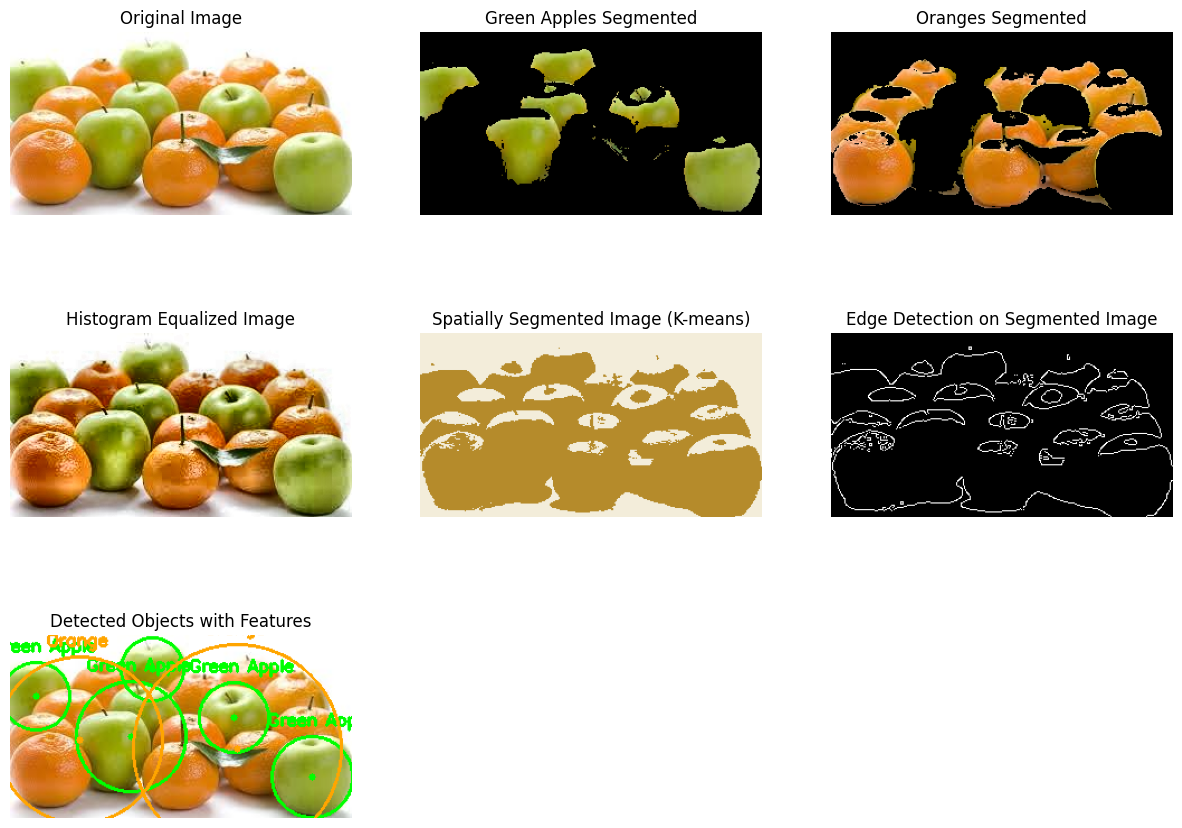

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

#step 1
# Load the image
image_path = "C:/Users/91924/Downloads/images.jpeg"
image = cv2.imread(image_path)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Segment the Image
# Define color ranges for green and orange
green_lower = np.array([25, 100, 100])
green_upper = np.array([85, 255, 255])
orange_lower = np.array([10, 100, 100])
orange_upper = np.array([25, 255, 255])

# Create masks for green and orange
green_mask = cv2.inRange(hsv, green_lower, green_upper)
orange_mask = cv2.inRange(hsv, orange_lower, orange_upper)

# Convert masks to color images for visualization
green_segmented = cv2.bitwise_and(image, image, mask=green_mask)
orange_segmented = cv2.bitwise_and(image, image, mask=orange_mask)

# Step 2: Histogram Equalization on Color Image using CLAHE
# Convert the image to YUV color space
yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
y_channel, u_channel, v_channel = cv2.split(yuv_image)

# Apply CLAHE to the Y channel
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_y = clahe.apply(y_channel)

# Merge the channels back
equalized_yuv = cv2.merge((clahe_y, u_channel, v_channel))
equalized_color = cv2.cvtColor(equalized_yuv, cv2.COLOR_YUV2BGR)

# Step 3: Spatial Segmentation (Using k-means clustering)
# Reshape the image into a 2D array of pixels
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Define criteria and apply k-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2  # Number of clusters
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back the clustered pixels to image format
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()].reshape(image.shape)

# Edge Detection (on Spatially Segmented Image)
# Convert the segmented image to grayscale for edge detection
gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray_segmented, 50, 150)

# Identify Objects of Interest (Contours for green and orange)
green_contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
orange_contours, _ = cv2.findContours(orange_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract Features from Each Object
def extract_features(contour):
    features = {}
    features['Area'] = cv2.contourArea(contour)
    features['Perimeter'] = cv2.arcLength(contour, True)
    x, y, w, h = cv2.boundingRect(contour)
    features['BoundingBox'] = (x, y, w, h)
    M = cv2.moments(contour)
    features['Centroid'] = (int(M['m10']/M['m00']), int(M['m01']/M['m00'])) if M['m00'] != 0 else (None, None)
    return features

# Extract features for green and orange
green_features = [extract_features(contour) for contour in green_contours if cv2.contourArea(contour) > 500]
orange_features = [extract_features(contour) for contour in orange_contours if cv2.contourArea(contour) > 500]

# Print extracted features
print("Green Apples Features:")
for i, features in enumerate(green_features):
    print(f"Object {i+1}: {features}")

print("\nOranges Features:")
for i, features in enumerate(orange_features):
    print(f"Object {i+1}: {features}")

# Analyze and Use the Features
# Example reference feature (you can adjust or calculate this based on actual reference)
reference_features = {'Area': 500, 'Perimeter': 100, 'BoundingBox': (0, 0, 0, 0), 'Centroid': (0, 0)}

# Draw contours and features
output_image = image.copy()

for contour in green_contours:
    if cv2.contourArea(contour) > 500:
        features = extract_features(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(output_image, center, radius, (0, 255, 0), 2)
        cv2.circle(output_image, center, 3, (0, 255, 0), -1)
        cv2.putText(output_image, 'Green Apple', (center[0] - 40, center[1] - radius - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

for contour in orange_contours:
    if cv2.contourArea(contour) > 500:
        features = extract_features(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(output_image, center, radius, (0, 165, 255), 2)
        cv2.circle(output_image, center, 3, (0, 165, 255), -1)
        cv2.putText(output_image, 'Orange', (center[0] - 30, center[1] - radius - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 165, 255), 2)

# Display the intermediate results for segmentation and edge detection
plt.figure(figsize=(15, 15))

plt.subplot(4, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(4, 3, 2)
plt.imshow(cv2.cvtColor(green_segmented, cv2.COLOR_BGR2RGB))
plt.title("Green Apples Segmented")
plt.axis('off')

plt.subplot(4, 3, 3)
plt.imshow(cv2.cvtColor(orange_segmented, cv2.COLOR_BGR2RGB))
plt.title("Oranges Segmented")
plt.axis('off')

plt.subplot(4, 3, 4)
plt.imshow(cv2.cvtColor(equalized_color, cv2.COLOR_BGR2RGB))
plt.title("Histogram Equalized Image")
plt.axis('off')

plt.subplot(4, 3, 5)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title("Spatially Segmented Image (K-means)")
plt.axis('off')

# Display edge detection result after spatial segmentation
plt.subplot(4, 3, 6)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
plt.title("Edge Detection on Segmented Image")
plt.axis('off')

# Display the final output image with contours
plt.subplot(4, 3, 7)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Objects with Features")
plt.axis('off')

plt.show()


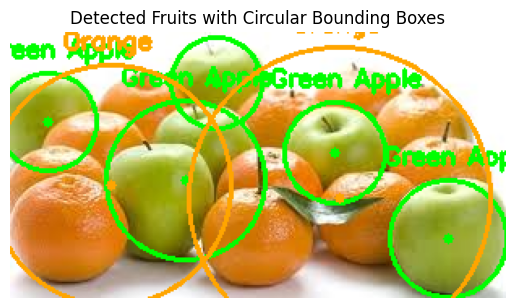

In [3]:
# Display the final result

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Fruits with Circular Bounding Boxes")
plt.axis('off')

plt.show()

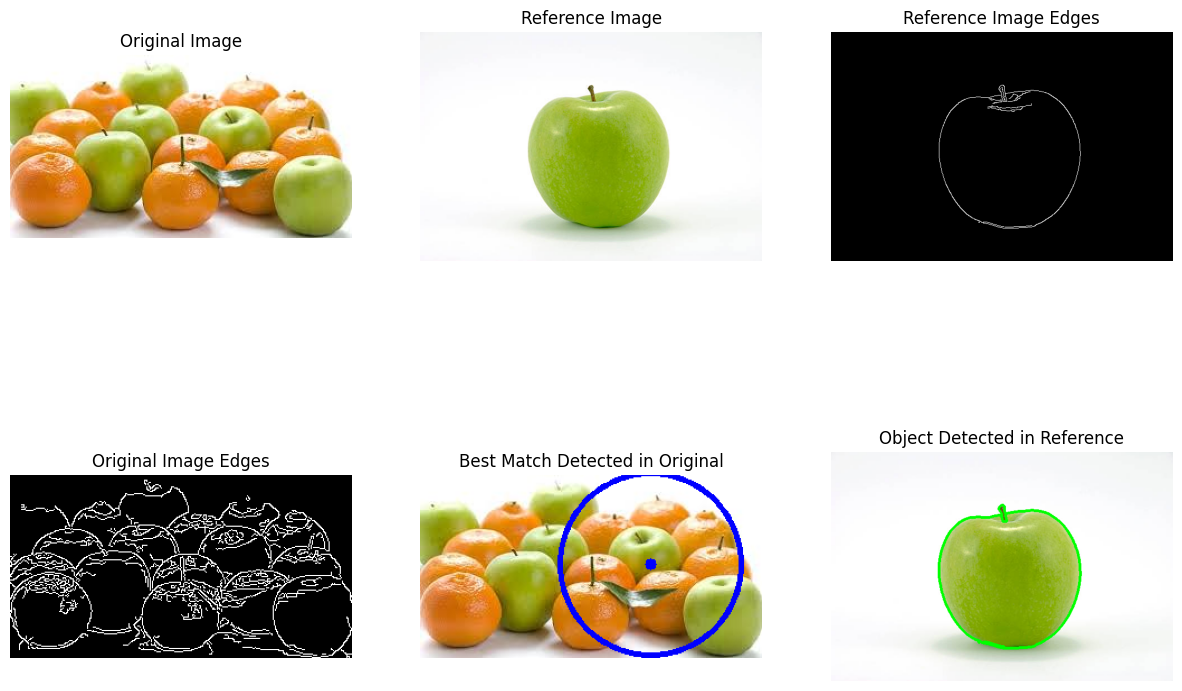

Labeled dataset saved to labeled_dataset.csv


In [21]:
import cv2
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pandas as pd

# Load both images
original_image_path = "C:/Users/91924/Downloads/images.jpeg"
reference_image_path = "C:/Users/91924/Downloads/istockphoto-172725245-612x612.jpg"

# Read the images
original_image = cv2.imread(original_image_path)
reference_image = cv2.imread(reference_image_path)

# Edge Detection on Reference Image
gray_ref = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
edges_ref = cv2.Canny(gray_ref, 50, 150)

# Find contours in reference image
contours_ref, _ = cv2.findContours(edges_ref, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour_ref = max(contours_ref, key=cv2.contourArea)

# Extract Features of the Object in the Reference Image
def extract_features(contour, image):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, -1)
    
    mean_val = cv2.mean(image, mask=mask) 
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate centroid
    M = cv2.moments(contour)
    centroid = (int(M['m10']/M['m00']), int(M['m01']/M['m00'])) if M['m00'] != 0 else (None, None)
    
    return {
        'color': mean_val,
        'area': area,
        'perimeter': perimeter,
        'bounding_box': (x, y, w, h),
        'centroid': centroid
    }

# Extract features from the reference object
ref_features = extract_features(largest_contour_ref, reference_image)

# Find Matching Object in the Original Image
gray_orig = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
edges_orig = cv2.Canny(gray_orig, 50, 150)
contours_orig, _ = cv2.findContours(edges_orig, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Function to compare color similarity
def color_distance(color1, color2):
    return distance.euclidean(color1[:3], color2[:3])  

best_match = None
best_distance = float('inf')

# Prepare a list to hold data for the labeled dataset
labeled_data = []

# Loop through all contours in the original image to find the best match
for contour in contours_orig:
    if cv2.contourArea(contour) < 500:  
        continue
    
    orig_features = extract_features(contour, original_image)
    
    # Compare color similarity
    dist = color_distance(ref_features['color'], orig_features['color'])
    
    if dist < best_distance:
        best_distance = dist
        best_match = contour

        # Append features to labeled_data list
        labeled_data.append({
            'color': orig_features['color'],
            'area': orig_features['area'],
            'perimeter': orig_features['perimeter'],
            'centroid_x': orig_features['centroid'][0],
            'centroid_y': orig_features['centroid'][1]
        })

# Visualize the Results
output_image = original_image.copy()
if best_match is not None:
    (x, y), radius = cv2.minEnclosingCircle(best_match)
    center = (int(x), int(y))
    radius = int(radius)
    cv2.circle(output_image, center, radius, (255, 0, 0), 3)
    cv2.circle(output_image, center, 5, (255, 0, 0), -1)

# Display images using matplotlib
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
plt.title("Reference Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(edges_ref, cmap='gray')
plt.title("Reference Image Edges")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(edges_orig, cmap='gray')
plt.title("Original Image Edges")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Best Match Detected in Original")
plt.axis('off')

ref_object = reference_image.copy()
cv2.drawContours(ref_object, [largest_contour_ref], -1, (0, 255, 0), 3)
plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(ref_object, cv2.COLOR_BGR2RGB))
plt.title("Object Detected in Reference")
plt.axis('off')

plt.show()

# Save labeled data to a CSV file
labeled_df = pd.DataFrame(labeled_data)
labeled_df.to_csv("C:/Users/91924/Downloads/labeled_dataset.csv", index=False)
print("Labeled dataset saved to labeled_dataset.csv")
